Train Data - Image Shape: (32, 28, 28, 1)
Train Data - Label Shape: (32,)
Epoch 1/5
21811/21811 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.7071 - loss: 1.0185
Epoch 2/5
21811/21811 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.7891 - loss: 0.6605
Epoch 3/5
21811/21811 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.7963 - loss: 0.6307
Epoch 4/5
21811/21811 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.7992 - loss: 0.6190
Epoch 5/5
21811/21811 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.8012 - loss: 0.6115
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8217 - loss: 0.5272
Test accuracy: 0.8222707509994507
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Labels: N


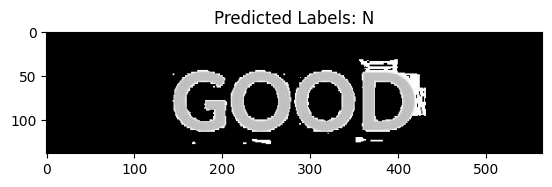

In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# EMNIST 데이터셋 로드
dataset, info = tfds.load("emnist", with_info=True, as_supervised=True)

# 훈련 데이터와 테스트 데이터로 나누기
train_data, test_data = dataset['train'], dataset['test']

# 데이터 전처리 함수 (정규화)
def preprocess(image, label):
    image = tf.cast(image, tf.float32)  # 이미지 타입을 float32로 변환
    image = image / 255.0  # 이미지 정규화 (0~1 범위)
    image = tf.reshape(image, (28, 28, 1))  # 28x28 크기로 리사이즈
    return image, label

# 데이터셋에 전처리 함수 적용 (배치 크기 32로 묶기)
train_data = train_data.map(preprocess).batch(32)
test_data = test_data.map(preprocess).batch(32)

# 데이터셋에 전처리 함수 적용
for image, label in train_data.take(1):
    print("Train Data - Image Shape:", image.shape)
    print("Train Data - Label Shape:", label.shape)

# 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),  # 배치 크기를 제외한 (28, 28) 이미지 크기만 설정
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(86, activation='softmax')  # EMNIST는 86개의 클래스 (A-Z, 0-9, 기타 문자)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
model.fit(train_data, epochs=5)

# 테스트 데이터로 성능 평가
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc}")

# 이미지에서 여러 개의 알파벳을 인식
def predict_multiple_characters(image_path):
    # 이미지 로드 및 전처리
    img = Image.open(image_path).convert('L')  # 흑백으로 변환
    img = np.array(img)
    
    # 이미지 전처리 (이진화)
    _, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    
    # 글자 분리 (연결된 부분을 찾고 분리하기)
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 각 글자마다 예측하기
    predicted_labels = []
    for contour in contours:
        # 바운딩 박스를 찾고 자르기
        x, y, w, h = cv2.boundingRect(contour)
        letter = img_bin[y:y+h, x:x+w]
        
        # 이미지를 28x28 크기로 리사이즈
        letter = cv2.resize(letter, (28, 28))
        letter = np.reshape(letter, (1, 28, 28))  # 배치 차원 추가
        
        # 예측
        letter = letter / 255.0  # 정규화
        prediction = model.predict(letter)
        predicted_label = np.argmax(prediction)  # 예측된 알파벳
        
        predicted_labels.append(chr(predicted_label + ord('A')))  # 알파벳으로 변환
    
    return predicted_labels

# 이미지 경로를 넣고 여러 알파벳 예측하기
image_path = '/home/seokwoo/Desktop/pngwing1.png'
predicted_labels = predict_multiple_characters(image_path)

print(f"Predicted Labels: {''.join(predicted_labels)}")

# 이미지 시각화
img = Image.open(image_path).convert('L')
plt.imshow(img, cmap='gray')
plt.title(f"Predicted Labels: {''.join(predicted_labels)}")
plt.show()